<a href="https://colab.research.google.com/github/rahulgangwal19/asl-ml-immersion/blob/master/TensorFlow_Computer_Vision_Model_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.__version__

'2.19.0'

In [ ]:
!pip list | grep tensorflow

tensorflow                               2.19.0
tensorflow-datasets                      4.9.9
tensorflow_decision_forests              1.12.0
tensorflow-hub                           0.16.1
tensorflow-metadata                      1.17.2
tensorflow-probability                   0.25.0
tensorflow-text                          2.19.0


To check if you have a GPU attached. Run the following

In [ ]:
# all TENSORFLOW NLP Libraries an Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import tensorflow as tf
import tensorflow_hub as hub # For pre-trained models like BERT
import tensorflow_datasets as tfds # For loading NLP datasets
import re # For text cleaning
import nltk # For general NLP tasks
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


In [ ]:
from pathlib import Path
from google.colab import drive

# 1. Mount Google Drive (this will bring up a pop-up to sign-in/authenticate)
# Note: This step is specifically for Google Colab, if you're working locally, you may need a different setup
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Read BOTTOM TO UP
# 2. Setup constants
# Note: For constants like this, you'll often see them created as variables with all capitals
TARGET_DRIVE_PATH = Path("/content/drive/MyDrive/ALMA_better/Tensor_pytorch/dog_vision_data/dog_vision_data")
TARGET_FILES = ["images.tar", "annotation.tar", "lists.tar"]
TARGET_URL = "http://vision.stanford.edu/aditya86/ImageNetDogs"

In [ ]:
# 3. Setup local path
local_dir = Path("dog_vision_data")

In [ ]:
# 4. Check if the target files exist in Google Drive, if so, copy them to Google Colab
if all((TARGET_DRIVE_PATH / file).is_file() for file in TARGET_FILES):
  print(f"[INFO] Copying Dog Vision files from Google Drive to local directory...")
  print(f"[INFO] Source dir: {TARGET_DRIVE_PATH} -> Target dir: {local_dir}")
  !cp -r {TARGET_DRIVE_PATH} .
  print("[INFO] Good to go!")

else:
  # 5. If the files don't exist in Google Drive, download them
  print(f"[INFO] Target files not found in Google Drive.")
  print(f"[INFO] Downloading the target files... this shouldn't take too long...")
  for file in TARGET_FILES:
    # wget is short for "world wide web get", as in "get a file from the web"
    # -nc or --no-clobber = don't download files that already exist locally
    # -P = save the target file to a specified prefix, in our case, local_dir
    !wget -nc {TARGET_URL}/{file} -P {local_dir} # the "!" means to execute the command on the command line rather than in Python

  print(f"[INFO] Saving the target files to Google Drive, so they can be loaded later...")

  # 6. Ensure target directory in Google Drive exists
  TARGET_DRIVE_PATH.mkdir(parents=True, exist_ok=True)

  # 7. Copy downloaded files to Google Drive (so we can use them later and not have to re-download them)
  !cp -r {local_dir}/* {TARGET_DRIVE_PATH}/

[INFO] Copying Dog Vision files from Google Drive to local directory...
[INFO] Source dir: /content/drive/MyDrive/ALMA_better/Tensor_pytorch/dog_vision_data/dog_vision_data -> Target dir: dog_vision_data
[INFO] Good to go!


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


In [ ]:
#local_dir is local_folder
if local_dir.exists():
  print(str(local_dir) + "/")
  for item in local_dir.iterdir():
    print("  ", item.name)

dog_vision_data/
   images.tar
   lists.tar
   annotation.tar


In [ ]:
# Untar images, notes/tags:
# -x = extract files from the zipped file
# -v = verbose
# -z = decompress files
# -f = tell tar which file to deal with
!tar -xf dog_vision_data/images.tar
!tar -xf dog_vision_data/annotation.tar
!tar -xf dog_vision_data/lists.tar

In [ ]:
import os
os.listdir(".") # "." stands for here and current directory

['.config',
 'train_list.mat',
 'drive',
 'test_list.mat',
 'dog_vision_data',
 'Images',
 'Annotation',
 'file_list.mat',
 'sample_data']

In [ ]:
import scipy

# open list of train and test .Mat
train_list = scipy.io.loadmat("train_list.mat")
test_list = scipy.io.loadmat("test_list.mat")
file_list = scipy.io.loadmat("file_list.mat")

# Let's inspect the outpu and type of the train_list
train_list,type(train_list)

({'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct  9 08:36:13 2011',
  '__version__': '1.0',
  '__globals__': [],
  'file_list': array([[array(['n02085620-Chihuahua/n02085620_5927.jpg'], dtype='<U38')],
         [array(['n02085620-Chihuahua/n02085620_4441.jpg'], dtype='<U38')],
         [array(['n02085620-Chihuahua/n02085620_1502.jpg'], dtype='<U38')],
         ...,
         [array(['n02116738-African_hunting_dog/n02116738_6754.jpg'], dtype='<U48')],
         [array(['n02116738-African_hunting_dog/n02116738_9333.jpg'], dtype='<U48')],
         [array(['n02116738-African_hunting_dog/n02116738_2503.jpg'], dtype='<U48')]],
        dtype=object),
  'annotation_list': array([[array(['n02085620-Chihuahua/n02085620_5927'], dtype='<U34')],
         [array(['n02085620-Chihuahua/n02085620_4441'], dtype='<U34')],
         [array(['n02085620-Chihuahua/n02085620_1502'], dtype='<U34')],
         ...,
         [array(['n02116738-African_hunting_dog/n02116738_6754'], dtype=

In [ ]:
# Get a Python list of all file names for each list
# item[0][0] is the OUTPUT

train_file_list = list([item[0][0] for item in train_list["file_list"]])
test_file_list = list([item[0][0] for item in test_list["file_list"]])
full_file_list = list([item[0][0] for item in file_list["file_list"]])

len(train_file_list),len(test_file_list),len(full_file_list)

(12000, 8580, 20580)

In [ ]:
import random
random.sample(train_file_list, k=10)

[np.str_('n02092002-Scottish_deerhound/n02092002_7165.jpg'),
 np.str_('n02106550-Rottweiler/n02106550_7608.jpg'),
 np.str_('n02101556-clumber/n02101556_4994.jpg'),
 np.str_('n02111500-Great_Pyrenees/n02111500_8209.jpg'),
 np.str_('n02106662-German_shepherd/n02106662_13599.jpg'),
 np.str_('n02096051-Airedale/n02096051_2333.jpg'),
 np.str_('n02100877-Irish_setter/n02100877_2551.jpg'),
 np.str_('n02092339-Weimaraner/n02092339_2941.jpg'),
 np.str_('n02106662-German_shepherd/n02106662_23691.jpg'),
 np.str_('n02110063-malamute/n02110063_540.jpg')]

In [ ]:
# How many files in the training set intersect with the testing set?
len(set(train_file_list).intersection(test_file_list))

0

In [ ]:
os.listdir("Annotation")[:10]

['n02107908-Appenzeller',
 'n02108000-EntleBucher',
 'n02097298-Scotch_terrier',
 'n02101556-clumber',
 'n02091831-Saluki',
 'n02087046-toy_terrier',
 'n02108089-boxer',
 'n02115641-dingo',
 'n02108551-Tibetan_mastiff',
 'n02098286-West_Highland_white_terrier']

In [ ]:
from pathlib import Path
def count_subfolders(directory_path:str) -> int:
  """
  Count the number of subfolders in a given direcory.

  Args:
  directory_path (str): the path to the directory in which to count subfolders.

  Returns:
  int: The number of subfolders in the specified directory.

  Examples:
  >>> count_subfolders('/path/to/directory')
  3 # if there are 3 subfolders in the specified directory

  """
  return len([name for name in Path(directory_path).iterdir() if name.is_dir()])

directory_path = "Annotation"
folder_count = count_subfolders(directory_path)
print(f"Number of subfolders in {directory_path} directory: {folder_count}")

Number of subfolders in Annotation directory: 120


In [ ]:
# Get a list of all images folder
image_folders = os.listdir("Images")
image_folders[:10]

['n02107908-Appenzeller',
 'n02108000-EntleBucher',
 'n02097298-Scotch_terrier',
 'n02101556-clumber',
 'n02091831-Saluki',
 'n02087046-toy_terrier',
 'n02108089-boxer',
 'n02115641-dingo',
 'n02108551-Tibetan_mastiff',
 'n02098286-West_Highland_white_terrier']

In [ ]:
# Create folder name -> class name dict
folder_to_class_name_dict = {}
for folder_name in image_folders:
  # Turn folder name into class_name
  # E.g. "n02089078-black-and-tan_coonhound" -> "black_and_tan_coonhound"
  # We'll split on the first "-" and join the rest of the string with "_" and then lower i

  class_name = "_".join(folder_name.split("-")[1:]).lower()
  folder_to_class_name_dict[folder_name] = class_name

# Make sure there are 120 entries in the dictionary
assert len(folder_to_class_name_dict)== 120

In [ ]:
dog_names = sorted(list(folder_to_class_name_dict.values()))
dog_names[:10]

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle']

In [ ]:
os.listdir(images_split_dir)

NameError: name 'images_split_dir' is not defined

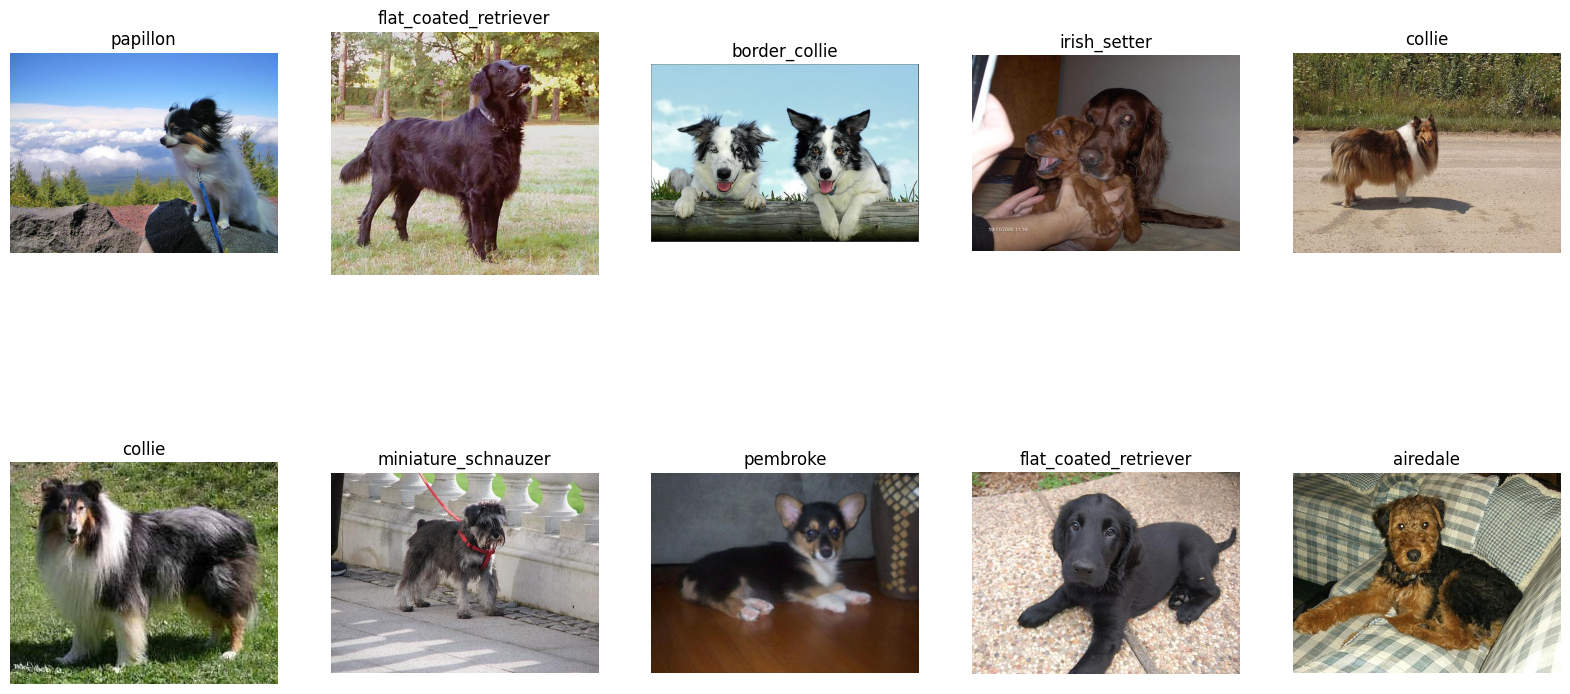

In [ ]:
import random

from pathlib import Path
from typing import List

import matplotlib.pyplot as plt

#1. Take in a select list of image paths
def plot_10_random_images_from_path_list(path_list: List[Path],extract_title: bool=True) -> None:
  #2. set up a grid of plots
  fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))

  #3. Randomly sample 10 paths from the list
  samples = random.sample(path_list, 10)

  #4. iterate through the flattened axes and corrospoding sample paths
  for i, ax in enumerate(axes.flat):

    #5. Get the target sample path (e.g. "Images/n02087394-Rhodesian_ridgeback/n02087394_1161.jpg")
    sample_path = samples[i]

    #6. Extract the parent directory name to use as the title(if necessary)
    # (e.g. n02087394-Rhodesian_ridgeback/n02087394_1161.jpg -> n02087394-Rhodesian_ridgeback -> rhodesian_ridgeback)
    if extract_title:
      sample_title = folder_to_class_name_dict[sample_path.parent.stem]
    else:
      sample_title = sample_path.parent.stem             # bug:Path

    #7. Read the image file and plot it on the corrosponding axis
    ax.imshow(plt.imread(sample_path))

    # 8. Set the title of the axis and turn of the axis (for pretty plots)
    ax.set_title(sample_title)
    ax.axis("off")

  #9. Display the plot
  plt.show()

plot_10_random_images_from_path_list(path_list=[Path("Images")/Path(file) for file in train_file_list])

In [ ]:
# ceate a dictionary of image counts
from typing import List,Dict

#1. Take in a target dictionary
def count_images_in_subdirs(target_dictionary: str) -> List[Dict[str,int]]:
  """
  Counts the number of JPEG images in each subdirectory of the given directory
  Each subdirectory is assumed to represent a class, and the function counts
  the number of '.jpg' files within each one. The result is a list of
  dictionaries with the class name and corresponding image count.

  Args:
  target_directory (str): The path to the directory containing subdirectories.

  Returns:
      List[Dict[str, int]]: A list of dictionaries with 'class_name' and 'image_count' for each subdirectory.

  Examples:
      >>> count_images_in_subdirs('/path/to/directory')
      [{'class_name': 'beagle', 'image_count': 50}, {'class_name': 'poodle', 'image_count': 60}]
  """
  # 2. Create a list of all the subdirectoires in the target directory (these contain our images)
  images_dir = Path("/content/Images")                # ERROR SUBFOLDER
  image_class_dirs = [directory for directory in images_dir.iterdir() if directory.is_dir()]
  #3. Create an empty list to image counts to
  image_class_counts = []
  #4. iterate through all of the subdirectories
  for image_class_dir in image_class_dirs:

    #5. Get the class name from image directory (e.g. "Images/n02116738-African_hunting_dog" -> "n02116738-African_hunting_dog")
    class_name = image_class_dir.stem

    #6. Count the number of images in the target subdirectory
    image_count = len(list(image_class_dir.rglob("*.jpg")))

    #7. Append a dictionary of class name and image count to count list
    image_class_counts.append({"class_name": class_name,
                                   "image_count": image_count})
   #8. Return the list
  return image_class_counts

In [ ]:
image_class_counts = count_images_in_subdirs("Images")
image_class_counts[:3]


[{'class_name': 'n02107908-Appenzeller', 'image_count': 151},
 {'class_name': 'n02108000-EntleBucher', 'image_count': 202},
 {'class_name': 'n02097298-Scotch_terrier', 'image_count': 158}]

In [ ]:
# Create a dataframe
import pandas as pd
image_counts_df = pd.DataFrame(image_class_counts).sort_values(by="image_count", ascending = False)
image_counts_df.head()

class_name  image_count
71         n02085936-Maltese_dog          252
23        n02088094-Afghan_hound          239
28  n02092002-Scottish_deerhound          232
22          n02112018-Pomeranian          219
83     n02090721-Irish_wolfhound          218

In [ ]:
# Make class name column EASIER to READ
image_counts_df["class_name"] = image_counts_df["class_name"].map(folder_to_class_name_dict)
image_counts_df.head()

class_name  image_count
71         maltese_dog          252
23        afghan_hound          239
28  scottish_deerhound          232
22          pomeranian          219
83     irish_wolfhound          218

In [ ]:
from pathlib import Path

# Define the target directory to for image splits to go
images_split_dir = Path("images_split")

# Define the training and test directories
train_dir = images_split_dir/"train"
test_dir = images_split_dir/"test"

# Using Path.mkdir with exist_ok = True ensures the directory is created only if it doesn't exist
train_dir.mkdir(parents=True,exist_ok=True)
test_dir.mkdir(parents=True,exist_ok=True)
print(f"Directory {train_dir} is exists.")
print(f"Directory {test_dir} is exists.")

# Make a folder for each dog name
for dog_name in dog_names:
  # making training dir folder
  train_class_dir = train_dir/dog_name
  train_class_dir.mkdir(parents=True,exist_ok=True)
  # print(f" Makein directory : {train_class_dir}")

  # Making testing dir folder
  test_class_dir = test_dir/dog_name
  test_class_dir.mkdir(parents=True,exist_ok=True)
  # print(f" Makein directory : {train_class_dir}")

assert count_subfolders(train_dir) == len(dog_names)   # Error(bug) found here
assert count_subfolders(test_dir) == len(dog_names)

Directory images_split/train is exists.
Directory images_split/test is exists.


In [ ]:
from pathlib import Path
from shutil import copy2
from tqdm.auto import tqdm

#1. Take in a list of source files to copy and a target directory
def copy_files_to_target_dir(file_list : list[str],
                                   target_dir : str,
                                   images_dir : str = "Images",
                                   verbose: bool = False) -> None:

                                   #2. Iterate through source files
                                   for file in tqdm(file_list):
                                    #3. Convert file path to a Path list
                                    source_file_path = Path(images_dir) / Path(file)
                                    #4. split the file path and create a Path object for the destination folder
                                    # e.g. "n02112018-Pomeranian" -> "pomeranian"
                                    file_class_name = folder_to_class_name_dict[Path(file).parts[0]]
                                    #5. Get the name of the target image
                                    file_image_name = Path(file).name
                                    #6. Create the destination path
                                    destination_file_path = Path(target_dir) / file_class_name / file_image_name
                                    #7. Ensure the destination directory exists (this is a safety check, can't copy an image to a file that doesn't exist)
                                    destination_file_path.parent.mkdir(parents = True, exist_ok = True)
                                    #8. Print out copy message if necessary
                                    if verbose:
                                       print(f"[info] Copying: {source_file_path} to {destination_file_path}")
                                    # 9. Copy the original path to the destination path
                                    copy2(src=source_file_path, dst = destination_file_path)

In [ ]:
copy_files_to_target_dir(file_list=train_file_list,
                         target_dir=train_dir,
                         verbose=False)

  0%|          | 0/12000 [00:00<?, ?it/s]

In [ ]:
copy_files_to_target_dir(file_list=test_file_list,
                         target_dir=test_dir,
                         verbose=False)

  0%|          | 0/8580 [00:00<?, ?it/s]

In [ ]:
# Get list of all .jpg paths in train and test image directories
train_image_paths = list(train_dir.rglob("*.jpg"))
test_image_paths = list(test_dir.rglob("*.jpg"))

# Make sure the number of images in the training and test directoriesequals the number for files
assert len(train_image_paths) == len(train_file_list)
assert len(test_image_paths) == len(test_file_list)

print(f"Number of images in {train_dir}: {len(train_image_paths)}")
print(f"Number of images in {test_dir}: {len(test_image_paths)}")

Number of images in images_split/train: 12000
Number of images in images_split/test: 8580


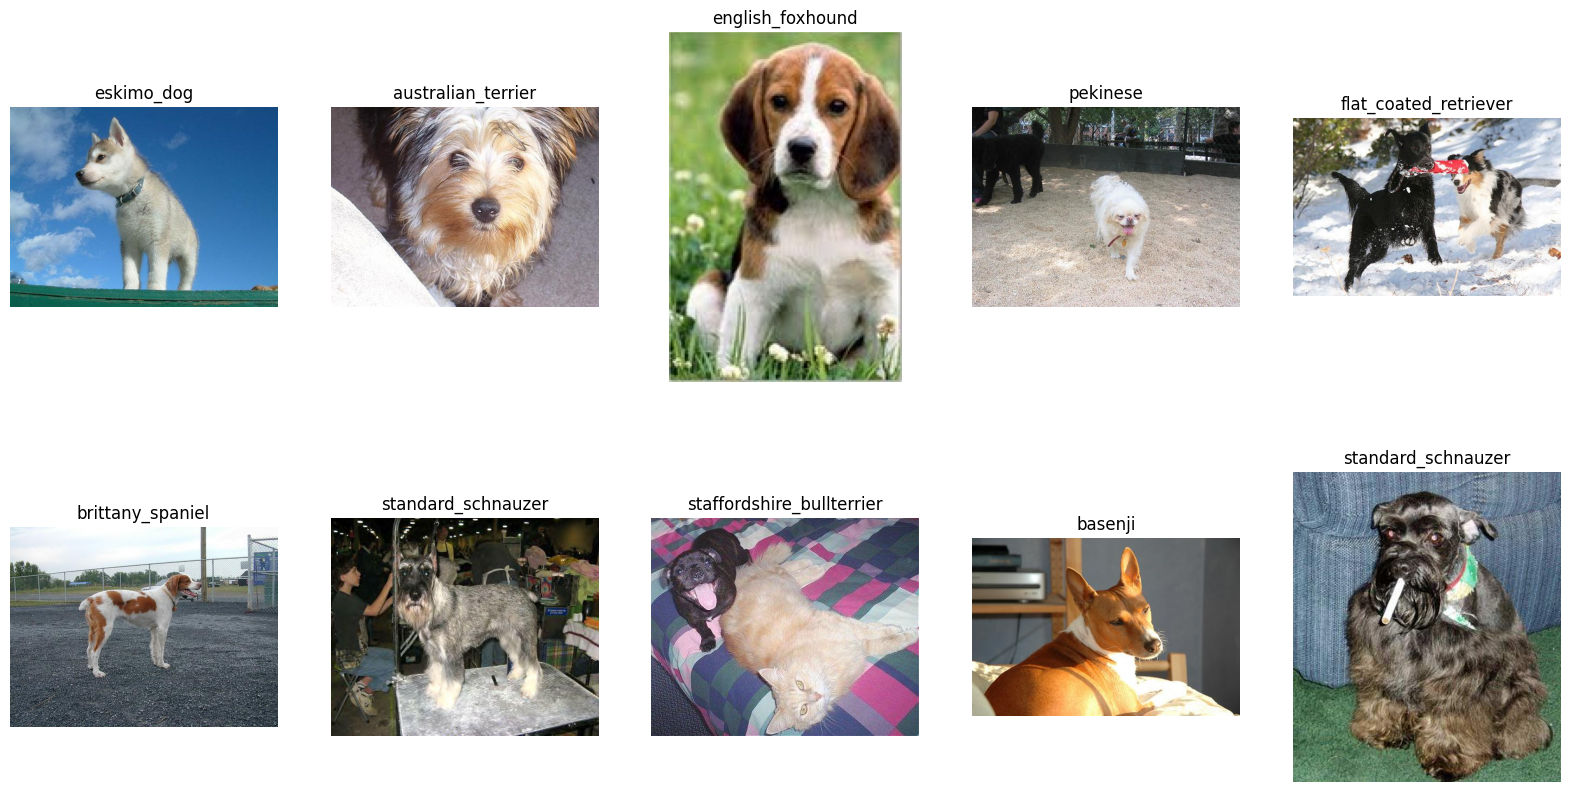

<function __main__.plot_10_random_images_from_path_list(path_list: List[pathlib.Path], extract_title: bool = True) -> None>

In [ ]:
plot_10_random_images_from_path_list(path_list=train_image_paths,
                                     extract_title=False) # Don't need to extract the title since the image directories are already named simple
plot_10_random_images_from_path_list

In [ ]:
# Create train_10_percent directory
train_10_percent_dir = images_split_dir / "train_10_percent"
train_10_percent_dir.mkdir(parents=True,exist_ok=True)

In [ ]:
import random

# set a ranodm seed
random.seed(42)

# Get a 10% sample of the training image paths
train_image_paths_random_10_percent = random.sample(population= train_image_paths,k=int(0.1*len(train_image_paths)))

# check how many image paths we got
print(f"Original number of training image paths:{len(train_image_paths)}")
print(f"Number of 10% training image paths: {len(train_image_paths_random_10_percent)}")
print(f"First 5 random 10% training image paths:")

train_image_paths_random_10_percent[:5]

Original number of training image paths:12000
Number of 10% training image paths: 1200
First 5 random 10% training image paths:


[PosixPath('images_split/train/newfoundland/n02111277_6143.jpg'),
 PosixPath('images_split/train/curly_coated_retriever/n02099429_2991.jpg'),
 PosixPath('images_split/train/brabancon_griffon/n02112706_1561.jpg'),
 PosixPath('images_split/train/leonberg/n02111129_5237.jpg'),
 PosixPath('images_split/train/great_pyrenees/n02111500_5801.jpg')]

In [ ]:
# Copy training 10% split images from images_split/train/ to images_split/train_10_percent/...
for source_file_path in tqdm(train_image_paths_random_10_percent):

  # Create the destination file path
  destination_file_and_image_name = Path(*source_file_path.parts[-2:])  # "images_split/train/yorkshire_terrier/n02094433_2223.jpg" -> "yorkshire_terrier/n02094433_2223.jpg"
  destination_file_path = train_10_percent_dir / destination_file_and_image_name # "yorkshire_terrier/n02094433_2223.jpg" -> "images_split/train_10_percent/yorkshire_terrier/n0209

  # if the target directory doesn't exist, make it.
  target_class_dir = destination_file_path.parent
  if not target_class_dir.is_dir():
    # print(f"Making directory:{target_class_dir}")
    target_class_dir.mkdir(parents=True,
                           exist_ok=True)
  # print(f"Copying: {sourcef_file_path} to {destination_file_path}")
  copy2(src=source_file_path,
        dst=destination_file_path)

  0%|          | 0/1200 [00:00<?, ?it/s]

In [ ]:
# Count images in train_10_percent_dir

train_10_percent_image_class_counts = count_images_in_subdirs(train_10_percent_dir)
train_10_percent_image_class_counts_df = pd.DataFrame(train_10_percent_image_class_counts).sort_values("image_count",ascending=True) # COLM = image_count
train_10_percent_image_class_counts_df.head()

class_name  image_count
34               n02090379-redbone          148
53              n02086079-Pekinese          149
3                n02101556-clumber          150
12  n02106382-Bouvier_des_Flandres          150
27   n02102973-Irish_water_spaniel          150

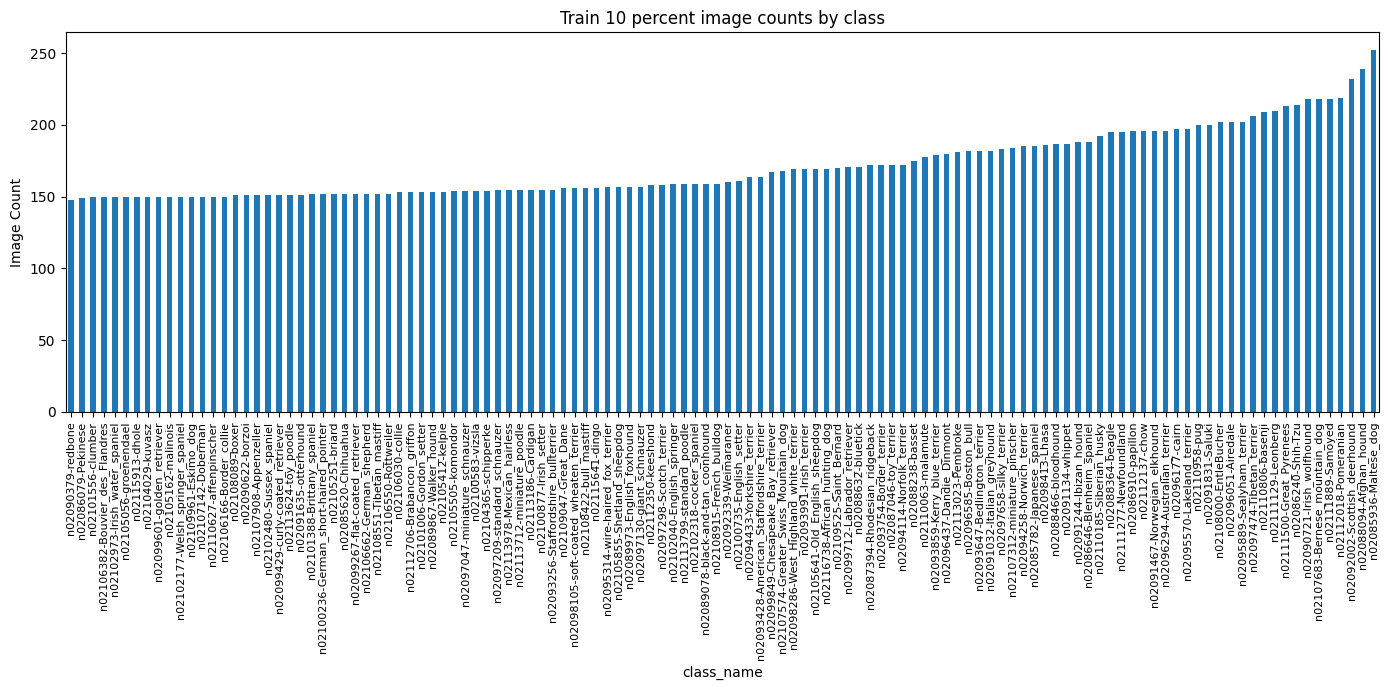

In [ ]:
# Plot distribution of train 10% dataset
plt.figure(figsize=(14,7))
train_10_percent_image_class_counts_df.plot(kind="bar",
                                            x="class_name",
                                            y="image_count",
                                            legend=False,
                                            ax=plt.gca()) # "get plt.gca", get the plt we setup above and put the data there
# Add Customization
plt.title("Train 10 percent image counts by class")
plt.ylabel("Image Count")
plt.xticks(rotation=90, # Rotate the X labels for better visibility
           fontsize=8)  # Make the font size smaller for easier Reading
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf

# Creat constants
IMG_SIZE = (224,224)
BATCH_SIZE = 32
SEED  = 42

# Create train 10% dataset
train_10_percent_ds = tf.keras.utils.image_dataset_from_directory(
    directory =train_10_percent_dir,
    label_mode ="categorical", # turn label into one-hot representations (e.g. [0, 0, 1, ..., 0, 0])
    batch_size =BATCH_SIZE,
    image_size =IMG_SIZE,
    shuffle =True, # shuffle training datasets to prevent learning of order
    seed=SEED
)

# Create full train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle =True,
    seed=SEED
)

# Create test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,  # don't need to shuffle the test dataset (this makes evaluations easier)
    seed=SEED
)

Found 1200 files belonging to 120 classes.
Found 12000 files belonging to 120 classes.
Found 8580 files belonging to 120 classes.


In [ ]:
# What does a single batch look like?
image_batch,label_batch = next(iter(train_ds))
image_batch.shape,label_batch.shape

(TensorShape([32, 224, 224, 3]), TensorShape([32, 120]))

In [ ]:
# Get a single sample from a single batch
print(f"Single image tensor:\n {image_batch[0]}\n")
print(f"Single label tensor:\n{label_batch[0]}") # Notice the 1 is the index of the target label(our labels are one hot encoded)
print(f"Single sample class name: {dog_names[tf.argmax(label_batch)[0]]}")

Single image tensor:
 [[[196.61607  174.61607  160.61607 ]
  [197.84822  175.84822  161.84822 ]
  [200.       178.       164.      ]
  ...
  [ 60.095097  79.75804   45.769207]
  [ 61.83293   71.22575   63.288315]
  [ 77.65755   83.65755   81.65755 ]]

 [[196.       174.       160.      ]
  [197.83876  175.83876  161.83876 ]
  [199.07945  177.07945  163.07945 ]
  ...
  [ 94.573715 110.55229   83.59694 ]
  [125.869865 135.26268  127.33472 ]
  [122.579605 128.5796   126.579605]]

 [[195.73691  173.73691  159.73691 ]
  [196.896    174.896    160.896   ]
  [199.       177.       163.      ]
  ...
  [ 26.679413  38.759026  20.500835]
  [ 24.372307  31.440136  26.675896]
  [ 20.214453  26.214453  24.214453]]

 ...

 [[ 61.57369   70.18976  104.72547 ]
  [189.91965  199.61607  213.28572 ]
  [247.26637  255.       252.70387 ]
  ...
  [113.40158   83.40158   57.40158 ]
  [110.75214   78.75214   53.752136]
  [107.37048   75.37048   50.370483]]

 [[ 61.27007   69.88614  104.42185 ]
  [188.93079  1

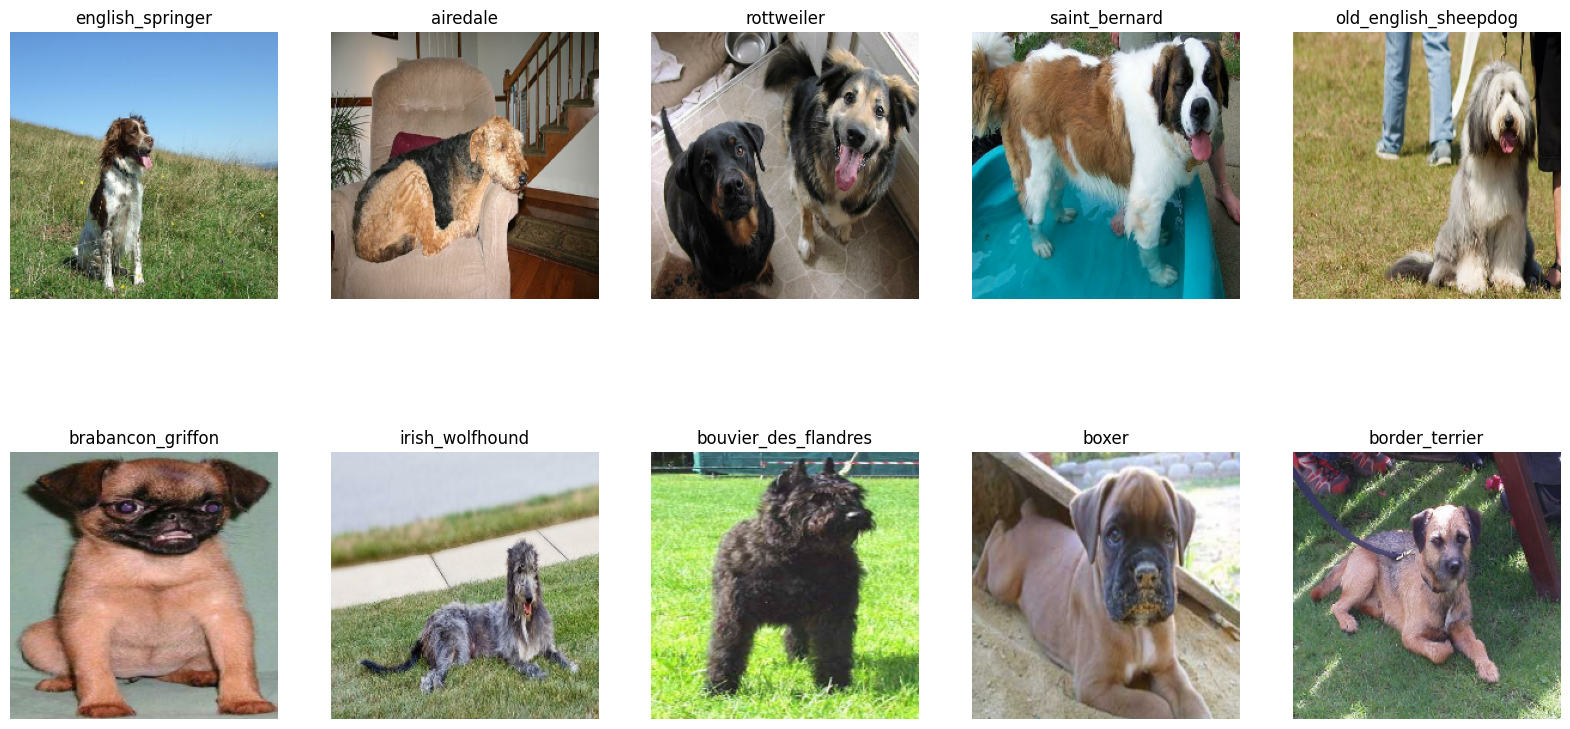

In [ ]:
# create multipe subplots
fig,axes = plt.subplots(nrows=2,
                        ncols=5,
                        figsize=(20,10))

for images,labels in train_ds.take(count=1):
  for i,ax in enumerate(axes.flat):
    ax.imshow(images[i].numpy().astype("uint8"))
    ax.set_title(dog_names[tf.argmax(labels[i])])
    ax.axis("off")

In [ ]:
# Get the first file paths of the training dataset
train_ds.file_paths[:5]

['images_split/train/boston_bull/n02096585_1753.jpg',
 'images_split/train/kerry_blue_terrier/n02093859_855.jpg',
 'images_split/train/border_terrier/n02093754_2281.jpg',
 'images_split/train/rottweiler/n02106550_11823.jpg',
 'images_split/train/airedale/n02096051_5884.jpg']

In [ ]:
train_10_percent_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>

In [ ]:
class_names = train_ds.class_names
class_names[:5]

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier']

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_10_percent_ds = train_10_percent_ds.cache().shuffle(buffer_size=10*BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.cache().shuffle(buffer_size=100*BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)



> # TensorFlow_Computer_Vision_Model_Part2_Transfer_Learning



---



---



---



---



In [ ]:
# Create the input shape to our model
INPUT_SHAPE = (*IMG_SIZE,3)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=True,
    include_preprocessing=True,
    weights="imagenet",
    input_shape=INPUT_SHAPE
)

29403144/29403144 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 7,200,312 (27.47 MB)

 Trainable params: 7,139,704 (27.24 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [ ]:
# Create a base model with No TOP
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top = False,
    include_preprocessing = True,
    weights = "imagenet" ,         # bug:"imageNet" N
    input_shape = INPUT_SHAPE
)

#Check the output shape
base_model.output_shape

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(None, 7, 7, 1280)

In [ ]:
# check the number of parameters
base_model.count_params()

5919312

In [ ]:
import numpy as np

def count_Parameters(model, print_output=True):
  """
  Counts the number of trainable, non-trainable and total parameters of a given model.
  """
  trainable_parameters = np.sum([np.prod(layer.shape) for layer in model.trainable_weights])
  non_trainable_parameters = np.sum([np.prod(layer.shape) for layer in model.non_trainable_weights])
  total_parameters         = trainable_parameters + non_trainable_parameters
  if print_output:
    print(f"Model {model.name}parameter counts:")
    print(f"Total parameters: {total_parameters}")
    print(f"Trainable parameters: {trainable_parameters}")
    print(f"Non-trainable parameters: {non_trainable_parameters}")
  else:
    return total_parameters, trainable_parameters, non-trainable_parameters

count_Parameters(model=base_model, print_output=True)

Model efficientnetv2-b0parameter counts:
Total parameters: 5919312
Trainable parameters: 5858704
Non-trainable parameters: 60608


In [ ]:
# freeze the base model
base_model.trainable=False
base_model.trainable

False

In [ ]:
count_Parameters(model=base_model,print_output=True)

Model efficientnetv2-b0parameter counts:
Total parameters: 5919312.0
Trainable parameters: 0.0
Non-trainable parameters: 5919312


In [ ]:
# Current image shape
shape_of_image_without_batch = image_batch[0].shape

# Adda batch dimension to our single image
shape_of_image_with_batch = tf.expand_dims(input=image_batch[0], axis=0).shape

print(f"Shape of image without batch: {shape_of_image_without_batch}")
print(f"Shape of image with batch: {shape_of_image_with_batch}")

Shape of image without batch: (224, 224, 3)
Shape of image with batch: (1, 224, 224, 3)


In [ ]:
# Extract features from a single image using our base model
feature_extraction = base_model(tf.expand_dims(image_batch[0], axis =0))
feature_extraction

<tf.Tensor: shape=(1, 7, 7, 1280), dtype=float32, numpy=
array([[[[-2.19177082e-01, -3.44185606e-02, -1.40321627e-01, ...,
          -1.44454509e-01, -2.73809791e-01, -7.41251782e-02],
         [-8.69670585e-02, -6.48750588e-02, -2.14547202e-01, ...,
          -4.57206406e-02, -2.77900130e-01, -8.20886344e-02],
         [-2.76872933e-01, -8.26781392e-02, -3.85151207e-02, ...,
          -2.72129059e-01, -2.52802223e-01, -2.28106007e-01],
         ...,
         [-1.01603933e-01, -3.55146267e-02, -2.23026931e-01, ...,
          -2.26227745e-01, -8.61772522e-02, -1.60451025e-01],
         [-5.87607436e-02, -4.65544593e-03, -1.06193364e-01, ...,
          -2.87548564e-02, -9.06914845e-02, -1.82624385e-01],
         [-6.27618283e-02, -1.38620916e-03,  1.52700013e-02, ...,
          -7.85450079e-03, -1.84584662e-01, -2.62404889e-01]],

        [[-2.17334077e-01, -1.10280894e-01, -2.74605244e-01, ...,
          -2.22405359e-01, -2.74738282e-01, -1.01998910e-01],
         [-1.40700579e-01, -1.6

In [ ]:
# Extract features from a single image using our base model
feature_extraction = base_model(tf.expand_dims(image_batch[0], axis=0))
feature_extraction

<tf.Tensor: shape=(1, 7, 7, 1280), dtype=float32, numpy=
array([[[[-2.19177082e-01, -3.44185606e-02, -1.40321627e-01, ...,
          -1.44454509e-01, -2.73809791e-01, -7.41251782e-02],
         [-8.69670585e-02, -6.48750588e-02, -2.14547202e-01, ...,
          -4.57206406e-02, -2.77900130e-01, -8.20886344e-02],
         [-2.76872933e-01, -8.26781392e-02, -3.85151207e-02, ...,
          -2.72129059e-01, -2.52802223e-01, -2.28106007e-01],
         ...,
         [-1.01603933e-01, -3.55146267e-02, -2.23026931e-01, ...,
          -2.26227745e-01, -8.61772522e-02, -1.60451025e-01],
         [-5.87607436e-02, -4.65544593e-03, -1.06193364e-01, ...,
          -2.87548564e-02, -9.06914845e-02, -1.82624385e-01],
         [-6.27618283e-02, -1.38620916e-03,  1.52700013e-02, ...,
          -7.85450079e-03, -1.84584662e-01, -2.62404889e-01]],

        [[-2.17334077e-01, -1.10280894e-01, -2.74605244e-01, ...,
          -2.22405359e-01, -2.74738282e-01, -1.01998910e-01],
         [-1.40700579e-01, -1.6

In [ ]:
num_input_features = 224*224*3
feature_extraction_features = 1*7*7*1280

# Calculate the compression ratio
num_input_features / feature_extraction_features

2.4

In [ ]:
# Turn feature extraction into a feature vector
feature_vector = tf.keras.layers.GlobalAveragePooling2D()(feature_extraction) # pass feature extraction to the pooling layer
feature_vector

<tf.Tensor: shape=(1, 1280), dtype=float32, numpy=
array([[-0.115219  , -0.04476556, -0.1247655 , ..., -0.09118074,
        -0.08420829, -0.07769412]], dtype=float32)>

In [ ]:
# Compare the reduction
num_input_features = 224*224*3
feature_extraction_features = 1*7*7*1280
feature_vector_features = 1*1280

print(f"Input -> feature extraction reduction factor: {num_input_features / feature_extraction_features}")
print(f"Feature extraction -> feature vector reduction factor: {feature_extraction_features / feature_vector_features }")
print(f"Input -> feature extraction -> feature vector reduction factor: {num_input_features / feature_vector_features}")

Input -> feature extraction reduction factor: 2.4
Feature extraction -> feature vector reduction factor: 49.0
Input -> feature extraction -> feature vector reduction factor: 117.6


In [ ]:
# Get a feature vector of a single image (Don't forget to add a batch dimension)
feature_vector_2 = base_model(tf.expand_dims(image_batch[0], axis=0))
feature_vector_2

<tf.Tensor: shape=(1, 7, 7, 1280), dtype=float32, numpy=
array([[[[-2.19177082e-01, -3.44185606e-02, -1.40321627e-01, ...,
          -1.44454509e-01, -2.73809791e-01, -7.41251782e-02],
         [-8.69670585e-02, -6.48750588e-02, -2.14547202e-01, ...,
          -4.57206406e-02, -2.77900130e-01, -8.20886344e-02],
         [-2.76872933e-01, -8.26781392e-02, -3.85151207e-02, ...,
          -2.72129059e-01, -2.52802223e-01, -2.28106007e-01],
         ...,
         [-1.01603933e-01, -3.55146267e-02, -2.23026931e-01, ...,
          -2.26227745e-01, -8.61772522e-02, -1.60451025e-01],
         [-5.87607436e-02, -4.65544593e-03, -1.06193364e-01, ...,
          -2.87548564e-02, -9.06914845e-02, -1.82624385e-01],
         [-6.27618283e-02, -1.38620916e-03,  1.52700013e-02, ...,
          -7.85450079e-03, -1.84584662e-01, -2.62404889e-01]],

        [[-2.17334077e-01, -1.10280894e-01, -2.74605244e-01, ...,
          -2.22405359e-01, -2.74738282e-01, -1.01998910e-01],
         [-1.40700579e-01, -1.6

In [ ]:
# Create a base model with no top and a pooling layer built-in
# pooling layer
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    pooling="avg", # can also use max
    include_preprocessing= True,
)

# check the summary (optional)
# base_model.summary()

# check the output shape
base_model.output_shape

(None, 1280)

In [ ]:
# Creating a sequential model
tf.random.set_seed(42)
sequential_model = tf.keras.Sequential([base_model,
                                        tf.keras.layers.Dense(units=len(dog_names),
                                                              activation="softmax")])
sequential_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,073,032 (23.17 MB)

 Trainable params: 6,012,424 (22.94 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [ ]:
# Get a single image with a batch size of 1
single_image_input = tf.expand_dims(image_batch[0], axis=0)

# Pass the image through our model
single_image_output_sequential = sequential_model(single_image_input)

# check the output
single_image_output_sequential

<tf.Tensor: shape=(1, 120), dtype=float32, numpy=
array([[0.00739369, 0.01007489, 0.00751212, 0.01037733, 0.00914727,
        0.01008707, 0.01617324, 0.01185679, 0.00503187, 0.00921297,
        0.01012353, 0.00688204, 0.00805084, 0.01020196, 0.00666245,
        0.00923445, 0.01081473, 0.01193087, 0.00912607, 0.00630283,
        0.0083983 , 0.00706253, 0.00451572, 0.00677444, 0.0090252 ,
        0.0114084 , 0.00605647, 0.00952479, 0.0048266 , 0.01249793,
        0.00576606, 0.00445981, 0.01085087, 0.00989168, 0.00493442,
        0.01055773, 0.00653175, 0.01026963, 0.00818802, 0.00829049,
        0.00495477, 0.00799628, 0.00694017, 0.00910843, 0.0062879 ,
        0.01003992, 0.00497214, 0.00914898, 0.00768118, 0.01054876,
        0.00986135, 0.01224062, 0.01172781, 0.00620302, 0.00845418,
        0.00493596, 0.0115492 , 0.01249467, 0.00354402, 0.00730537,
        0.00721891, 0.00927392, 0.00461553, 0.00538652, 0.01060425,
        0.01034137, 0.00852691, 0.01131643, 0.00986233, 0.00489516

In [ ]:
# Sum the output
np.sum(single_image_output_sequential)

np.float32(1.0)

In [ ]:
# Create an input layer
inputs = tf.keras.Input(shape=INPUT_SHAPE)

# Create hidden layer
x = base_model(inputs,training=False)

# Create the output layer
outputs = tf.keras.layers.Dense(units = len(class_names),
                                activation = "softmax",
                                name = "output_layer")(x)

# Connect the inputand output together
functional_model = tf.keras.Model(inputs=inputs,
                                  outputs=outputs,
                                  name="functional_model")
# Get a model_summary
functional_model.summary()

Model: "functional_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 120)            │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,073,032 (23.17 MB)

 Trainable params: 6,012,424 (22.94 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [ ]:
# Pass a single image through our functional_model
single_image_output_functional = functional_model(single_image_input)

# Find the index with the highest value
highest_value_index_functional_model_output = np.argmax(single_image_output_functional)
highest_value_functional_model_output = np.max(single_image_output_functional)

highest_value_index_functional_model_output, highest_value_functional_model_output

(np.int64(51), np.float32(0.0179923))

# Creating our base model

Let’s see if we can adjust those patterns slightly to our dog images.

To do this, we’ll create an instance of it and call it base_model.

In [ ]:
# check the original lable value
print(f"Predicted value: {highest_value_index_sequential_model_output}")
print(f"Actual value: {tf.argmax(label_batch[0].numpy())}")

NameError: name 'highest_value_index_sequential_model_output' is not defined

In [ ]:
# Index on class_names with our model's highest prediction probablity

sequential_model_predicted_label = class_names[tf.argmax(sequential_model(tf.expand_dims(image_batch[0],axis=0)),axis=1).numpy()[0]]

# Get the truth label
single_image_ground_truth_label = class_names[tf.argmax(label_batch[0])]

# Print predicted and ground truth labels
print(f"Sequential model predicted label: {sequential_model_predicted_label}")
print(f"Ground truth label: {single_image_ground_truth_label}")

Sequential model predicted label: australian_terrier
Ground truth label: schipperke


In [ ]:
def create_model(include_top: bool = False,
                 num_classes: int = 1000,
                 input_shape: tuple[int,int,int] = (224,224,3),
                 include_preprocessing: bool = True,
                 trainable: bool = False,
                 dropout: float = 0.2,
                 model_name: str = "model") -> tf.keras.Model:

   """
   Create an EfficientNetV2 B0 fature extractor model with a custom classifier model.

   Args:
   include_top(bool,optional): whether to include the top(classifier) layers of the model
   num_classes (int, optional): Number of output classes for the classifier layer.
   input_shape (tuple[int, int, int], optional): Input shape for the model's images (height, width, channels).
   include_preprocessing (bool, optional): Whether to include preprocessing layers for image normalization.
   trainable (bool, optional): Whether to make the base model trainable.
   dropout (float, optional): Dropout rate for the global average pooling layer.
   model_name (str, optional): Name for the created model.

   Returns:
    tf.keras.Model: A Tensorflow model with the specified configuration.

   """

   # Create base model
   base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
        include_top=include_top,
        weights='imagenet',
        input_shape=None,
        pooling="avg",
        include_preprocessing=include_preprocessing
    )

   # Freeze the base model (if neceassary)
   base_model.trainable = trainable

   # Create input label
   inputs = tf.keras.Input(shape=input_shape,name="input_layer")

   # Create model BACKBONE (MIDDLE /HIDDEN layer)
   x = base_model(inputs,training=trainable)

   # Create Output layer
   outputs = tf.keras.layers.Dense(units = num_classes,
                                   activation = "softmax",
                                   name = "output_layer")(x)

   # Connect input and output layer
   model = tf.keras.Model(inputs=inputs,
                          outputs=outputs,
                          name=model_name)
   return model

In [ ]:
# Create a model
model_0 = create_model(num_classes=len(class_names))
model_0.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 120)            │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,073,032 (23.17 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
for layer in model_0.layers:
  print(layer.name,layer.trainable)

input_layer True
efficientnetv2-b0 False
output_layer True


In [ ]:
# Create model
model_0 = create_model(num_classes=len(class_names),
                       model_name="model_0")
model_0.summary()

Model: "model_0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 120)            │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,073,032 (23.17 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
# create optimizer
optimizer = "adam"

# The above line is the same as above
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer

In [ ]:
# check that our labels are one hot encoded
label_batch[0]

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>

In [ ]:
# create our loss function
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False) # use from_logits = False if using an activation function in final layer of model
loss

<LossFunctionWrapper(<function categorical_crossentropy at 0x7dc5fcee7420>, kwargs={'from_logits': False, 'label_smoothing': 0.0, 'axis': -1})>

In [ ]:
# Create list of evaluation metrics
metrics = ['accuracy']

In [ ]:
# Create the input shape to our model
INPUT_SHAPE = (*IMG_SIZE,3)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=True,
    include_preprocessing=True,
    weights="imagenet",
    input_shape=INPUT_SHAPE
)




In [ ]:
# Compile model with shortcuts (faster to write code but less customizable)
model_0.compile(optimizer="adam",
                loss="categorical_crossentropy",
                metrics=["accuracy"])

# compile model with classes (will do the same as above)
model_0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=["accuracy"])

In [ ]:
# fit model_0 for 5 epochs
epochs = 5
history_0 = model_0.fit(x=train_10_percent_ds,
                        epochs=epochs,
                        validation_data=test_ds)

Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.1320 - loss: 4.4342 - val_accuracy: 0.5382 - val_loss: 3.0939
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.7246 - loss: 2.4314 - val_accuracy: 0.6809 - val_loss: 1.9461
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.8442 - loss: 1.3547 - val_accuracy: 0.7522 - val_loss: 1.3693
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.9185 - loss: 0.8079 - val_accuracy: 0.7879 - val_loss: 1.0761
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.9476 - loss: 0.5547 - val_accuracy: 0.8056 - val_loss: 0.9173


In [ ]:
# Inspect History.history attribute for model_0
history_0.history

{'accuracy': [0.26499998569488525,
  0.7266666889190674,
  0.8666666746139526,
  0.9208333492279053,
  0.9549999833106995],
 'loss': [3.996079921722412,
  2.179781436920166,
  1.2207763195037842,
  0.7659460306167603,
  0.5353943109512329],
 'val_accuracy': [0.538228452205658,
  0.6808857917785645,
  0.7522144317626953,
  0.7878788113594055,
  0.8055943846702576],
 'val_loss': [3.0938894748687744,
  1.946130394935608,
  1.3692739009857178,
  1.0761187076568604,
  0.9173439145088196]}

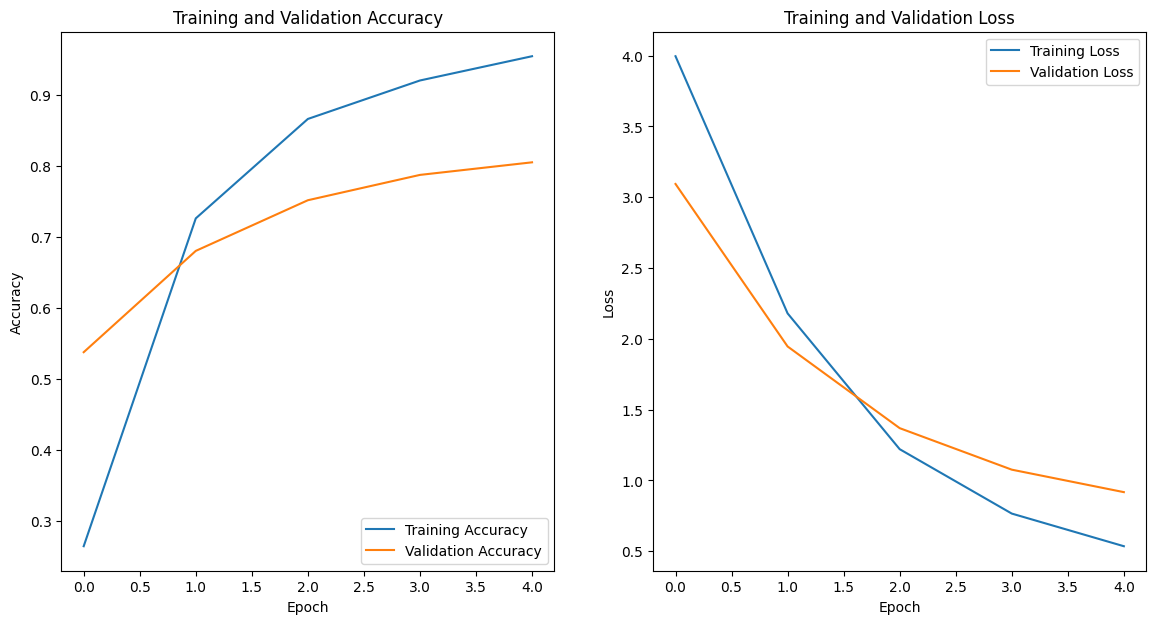

In [ ]:
def plot_model_loss_curves(history: tf.keras.callbacks.History) -> None:

  """
  Takes a History object and plots loss and accuracycurves.
  """
  # Get the accuracy values
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]

  # Get the loss values
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  # Get the number of epochs
  epochs_range = range(len(acc))

  #Create accuracy curves plot
  plt.figure(figsize=(14,7))
  plt.subplot(1,2,1)
  plt.plot(epochs_range, acc, label="Training Accuracy")
  plt.plot(epochs_range, val_acc, label="Validation Accuracy")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")

  # Create loss curves plot
  plt.subplot(1,2,2)
  plt.plot(epochs_range, loss, label="Training Loss")
  plt.plot(epochs_range, val_loss, label="Validation Loss")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.show()

plot_model_loss_curves(history=history_0)

In [ ]:
# Evaluate model_0, see: https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate
model_0_results = model_0.evaluate(x=test_ds)
model_0_results

269/269 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8274 - loss: 0.8715


[0.9173439145088196, 0.8055943846702576]

In [ ]:
# Get our model's metrics names
model_0.metrics_names

['loss', 'compile_metrics']

In [ ]:
#1. Create model_1 (next iternation of model_0)
model_1 = create_model(num_classes=len(class_names),
                       model_name = "model_1")

#2. Compile model
model_1.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
                loss = "categorical_crossentropy",
                metrics = ["accuracy"])

#3. fit model
epochs = 5
history_1 = model_1.fit(x = train_ds,
                        epochs = epochs,
                        validation_data = test_ds) # test_ds = test dataset

NameError: name 'create_model' is not defined

# Note:
A feature vector is also referred to as an embedding. This is basically a compressed representation of a data sample that makes it useful.

The concept of embeddings is not limited to images either, the concept of embeddings stretches across all data types (text, images, video, audio + more).

In [ ]:
# deliberate error
# Extract features from a single image using our base model
feature_extraction = base_model(image_batch[0])
feature_extraction